# Training and validation data

In this section we create two image data generators. The training generator takes a image and transforms it by the defined values in test_datagen (See next section). We implemented some simple zooming, shifting and rotation. This helps us to get alot of unique images out of a small dataset. In addition we have a test image data generator. This generator simply takes the image and rescales by 1./255. When we validate or test the network we don't want to manypulate real world data. The general term for this is image augmentation.

After generator creation we provide them with images from our directory ../images/crosslight/train and ../images/crosslight/validation. Every folder in this directory will be transformed to a feature. Because this network uses a binary classifier we need to make sure that there are only two features available, red and green.

In [1]:
from keras.preprocessing.image import ImageDataGenerator

image_height = 128
image_width = 128
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=False,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'iamges/crosslight/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../images/crosslight/train',  # this is the target directory
        target_size=(image_height, image_width),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../images/crosslight/validation',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')

Using TensorFlow backend.


Found 200 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


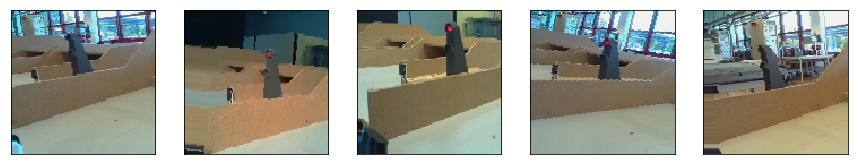

In [2]:
import matplotlib.pyplot as plt

stop = 1
plt.figure(figsize=(15, 6))
n = 5

for batch in train_generator:
    # display original
    ax = plt.subplot(2, n, stop)
    plt.imshow(batch[0][0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    stop +=1
    if stop>5:
        break
plt.show()

# Defining our Convolutional Neural Network

In the next section we define out convoluutional neural network. The basic of deep learning is stacking a lot of layers on top of each other to create a deep and more robust neural network. We have implemented three layers Convolutional 2D with rectifier activation and maxpooling. This is a best practice method and used in known nets like VGG16 / VGG19. Afterwards we flatten our filters and add a dense (normal neural network layer) with rectifier activation. To prevent our network from overfitting there is a dropout layer and the final dense sigmoid layer to see probability distribution on the possible outcomes. Our model summary shows how many parameters we need for the network. In order to have a good performance on a raspberry pi we trim the network to the least parameters we could.

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


model = Sequential()
model.add(Conv2D(8, (3, 3), input_shape=(image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 8)         584       
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         584       
__________

# Train the network

Finaly we provide the data from the generators to our network. Our training procedure contains hundred iterations training and then we validate on real world data that is not used for training. This helps us determine if the network works with images it has not seen before. After training we save our model weights to ../models/crosslight.h5

In [5]:
model.fit_generator(
        train_generator,
        steps_per_epoch=1600 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=160  // batch_size)

Epoch 1/10
100/100 [==============================] - 18s - loss: 0.6922 - acc: 0.5274 - val_loss: 0.6781 - val_acc: 0.5833

In [6]:
model.save_weights('../models/crosslight.h5')  # always save your weights after training or during training

# Test the network

Our network is finally trained and contains all the knowledge to classify new images. In this step we test the network on it's knowledge. All images are new to the network so it can not know them from the past. We make a prediction for every image and will see how good it performs. This is like our final exam to determine if the learning process was successful or not.

In [7]:
test_generator = test_datagen.flow_from_directory(
        '../images/crosslight/test',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')

Found 26 images belonging to 2 classes.


In [8]:
model.evaluate_generator(
        test_generator,
        steps=100)

[0.015379320284029326, 1.0]

We can see that our network can detect the crosslight with a 100% accuracy on the test data. This validates our network and we know it's ready for productional use.